In [8]:
import glob
import os
import torch
import torch.nn.functional as F
from torch import nn, Tensor
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from torchvision.io import read_image
from PIL import Image
from typing import Optional, Tuple, Union
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE
import logging
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image import StructuralSimilarityIndexMeasure
from torch.utils.data import ConcatDataset
import torch_fidelity
from pytorch_fid import fid_score
from skimage.metrics import structural_similarity as ssim
from PIL import Image


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec  1 23:16:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              47W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:

print(torch.__version__)
print(torch.cuda.is_available())


2.5.1+cu121
True


In [ ]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")


In [ ]:
if tf.config.list_physical_devices('GPU'):
    strategy = tf.distribute.MirroredStrategy()
    print("Running on GPU.")
else:
    strategy = tf.distribute.get_strategy()
    print("Running on CPU.")


Running on GPU.


In [13]:
from google.colab import files
uploaded = files.upload()

Saving images.zip to images.zip


In [ ]:
!unzip images.zip

In [ ]:
!ls monet_jpg
!ls berkeley_monet
!ls photo_jpg

In [19]:
MONET_DIR = "./monet_jpg/*.jpg"
BERKELEY_DIR = "./berkeley_monet/*.jpg"
PHOTO_DIR = "./photo_jpg/*.jpg"
BATCH_SIZE = 4
IN_CHANNELS = 3
OUT_CHANNELS = 3
HID_CHANNELS = 64
LR = 2e-4
BETAS = (0.5, 0.999)
LAMBDA = 10
NUM_EPOCHS = 200
DISPLAY_EPOCHS = 30
IMAGE_SIZE = 256
LOAD_SIZE = 286

In [20]:
import glob
print("Monet images:", len(glob.glob(MONET_DIR)))
print("Berkeley images:", len(glob.glob(BERKELEY_DIR)))
print("Photo images:", len(glob.glob(PHOTO_DIR)))

Monet images: 300
Berkeley images: 1193
Photo images: 7038


In [23]:
def decode_jpg_image(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = (img / 127.5) - 1
    img = tf.reshape(img, [256, 256, 3])
    # convert to pytorch form
    img = tf.transpose(img, [2, 0, 1])
    # convert to pytorch tensor
    return torch.from_numpy(img.numpy())

def parse_tfrec(serialized_image):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    serialized_image = tf.io.parse_single_example(serialized_image, tfrecord_format)
    img = decode_jpg_image(serialized_image['image'])
    return img

In [24]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def create_tfrecord(image_paths, output_path):
    with tf.io.TFRecordWriter(output_path) as writer:
        for img_path in image_paths:

            image_raw = tf.io.read_file(img_path)

            image_name = os.path.basename(img_path)

            feature = {
                'image_name': _bytes_feature(str.encode(image_name)),
                'image': _bytes_feature(image_raw),
                'target': _bytes_feature(str.encode(''))
            }

            example = tf.train.Example(features=tf.train.Features(feature=feature))

            writer.write(example.SerializeToString())


In [25]:
monet_files = sorted(glob.glob(MONET_DIR))
photo_files = sorted(glob.glob(PHOTO_DIR))
berkeley_files = sorted(glob.glob(BERKELEY_DIR))

# tf records output dir
os.makedirs("tfrecords", exist_ok=True)

#create TfRecord files
create_tfrecord(monet_files, "tfrecords/monet.tfrec")
create_tfrecord(photo_files, "tfrecords/photo.tfrec")
create_tfrecord(berkeley_files, "tfrecords/berkeley.tfrec")

# new path
monet_tfrec = "tfrecords/monet.tfrec"
photo_tfrec = "tfrecords/photo.tfrec"
berkeley_tfrec = "tfrecords/berkeley.tfrec"

if(monet_tfrec and photo_tfrec and berkeley_tfrec):
  print("yes")


yes


In [26]:
def show_img(img_tensor, nrow=5, title=""):
    img_tensor = img_tensor.detach().cpu()*0.5 + 0.5
    img_grid = make_grid(img_tensor, nrow=nrow).permute(1, 2, 0)
    plt.figure(figsize=(18, 8))
    plt.imshow(img_grid)
    plt.axis("off")
    plt.title(title)
    plt.show()


class CustomTransform:
    def __init__(self, load_dim: int = LOAD_SIZE, target_dim: int = IMAGE_SIZE):
        self.fit_transform = transforms.Compose([
            transforms.Resize((target_dim, target_dim))
        ])
        self.predict_transform = transforms.Compose([
            transforms.Resize((target_dim, target_dim))
        ])

    def __call__(self, img: Tensor, stage: str = "fit") -> Tensor:
        if not isinstance(img, torch.Tensor):
            img = transforms.functional.to_tensor(img)
        if stage == "fit":
            return self.fit_transform(img)
        else:
            return self.predict_transform(img)


class CustomDataset(Dataset):
    def __init__(self, tfrecord_files, transform=None, stage="fit"):
        self.dataset = tf.data.TFRecordDataset(tfrecord_files)
        self.transform = transform
        self.stage = stage
        self.length = sum(1 for _ in self.dataset)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        example = next(iter(self.dataset.skip(idx).take(1)))
        img = parse_tfrec(example)

        if self.transform:
            img = self.transform(img)
        return img


class CustomDataModule(pl.LightningDataModule):
    def __init__(
        self,
        monet_tfrec,
        berkeley_tfrec,
        photo_tfrec,
        batch_size=BATCH_SIZE,
        transform=None,
    ):
        super().__init__()
        self.monet_tfrec = monet_tfrec
        self.berkeley_tfrec = berkeley_tfrec
        self.photo_tfrec = photo_tfrec
        self.batch_size = batch_size
        self.transform = transform

    def setup(self, stage):
        if stage == "fit":
            self.art_dataset = ConcatDataset([
                CustomDataset(self.monet_tfrec, transform=self.transform, stage=stage),
                CustomDataset(self.berkeley_tfrec, transform=self.transform, stage=stage)
            ])
            self.photo_dataset = CustomDataset(
                self.photo_tfrec,
                transform=self.transform,
                stage=stage
            )

            self.min_dataset_size = min(len(self.art_dataset), len(self.photo_dataset))
        elif stage == "predict":
            self.predict_dataset = CustomDataset(
                self.photo_tfrec,
                transform=self.transform,
                stage=stage
            )

    def train_dataloader(self):
        art_sampler = torch.utils.data.RandomSampler(
            self.art_dataset,
            num_samples=self.min_dataset_size,
            replacement=True
        )
        photo_sampler = torch.utils.data.RandomSampler(
            self.photo_dataset,
            num_samples=self.min_dataset_size,
            replacement=True
        )

        return [
            DataLoader(
                self.art_dataset,
                batch_size=self.batch_size,
                sampler=art_sampler,
                pin_memory=True,
                drop_last=True
            ),
            DataLoader(
                self.photo_dataset,
                batch_size=self.batch_size,
                sampler=photo_sampler,
                pin_memory=True,
                drop_last=True
            )
        ]

    def predict_dataloader(self):
        return DataLoader(
            self.predict_dataset,
            batch_size=self.batch_size,
            pin_memory=True,
            drop_last=False
        )


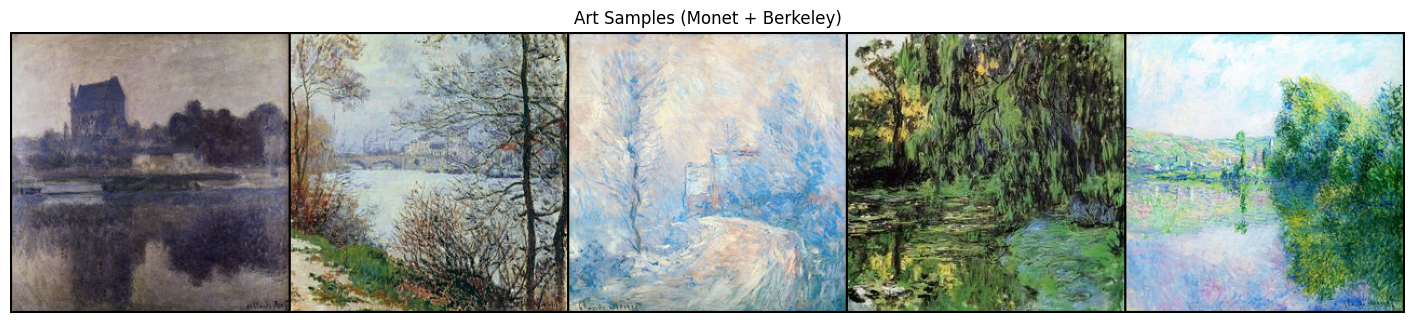

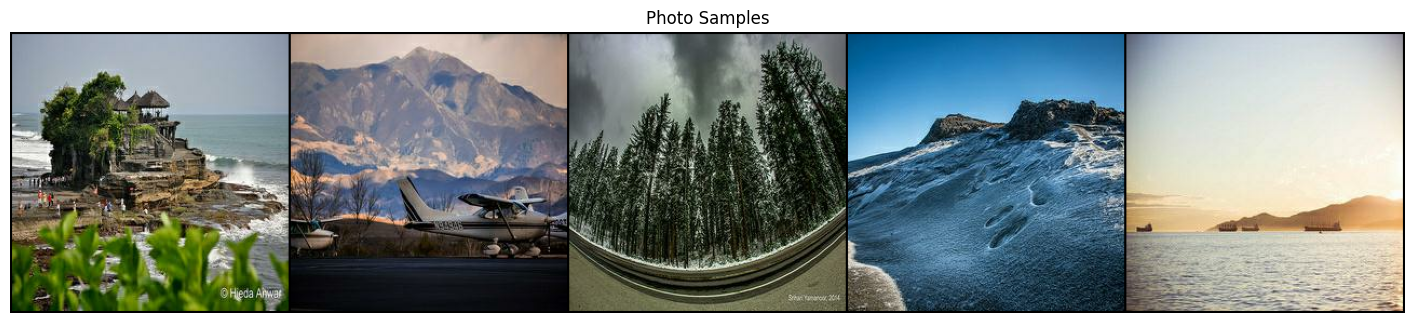

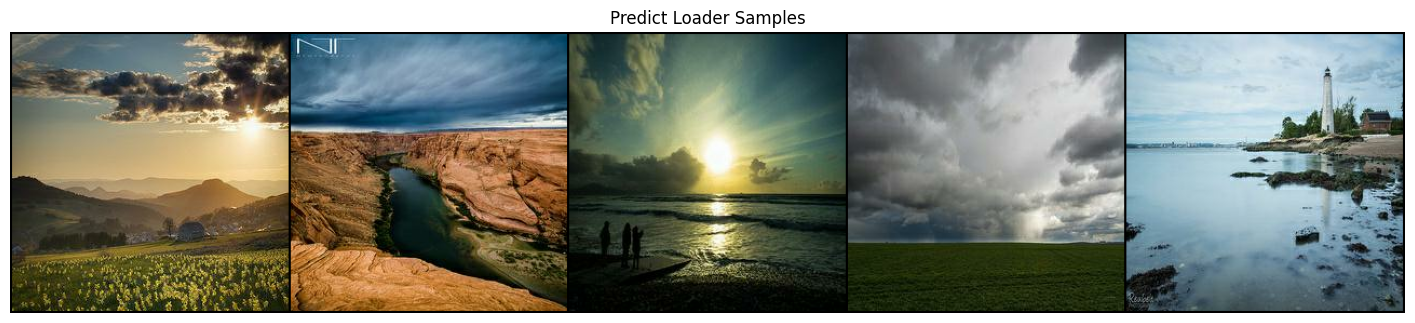

In [27]:
# sample data module
dm_sample = CustomDataModule(
    monet_tfrec=monet_tfrec,
    berkeley_tfrec=berkeley_tfrec,
    photo_tfrec=photo_tfrec,
    batch_size=5
)



dm_sample.setup("fit")
dm_sample.setup("predict")

# get training samples
train_loaders = dm_sample.train_dataloader()
art_samples = next(iter(train_loaders[0]))  # Combined Monet and Berkeley
photo_samples = next(iter(train_loaders[1]))  # Photos

# get prediction samples
predict_loader = dm_sample.predict_dataloader()
predict_samples = next(iter(predict_loader))

# show samples
show_img(art_samples, title="Art Samples (Monet + Berkeley)")
show_img(photo_samples, title="Photo Samples")
show_img(predict_samples, title="Predict Loader Samples")

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)  # skip connection

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=64, num_residual_blocks=9):
        super().__init__()
        #convolution
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(features),
            nn.ReLU(inplace=True)
        )

        # downsampling
        self.downsampling = nn.Sequential(
            nn.Conv2d(features, features * 2, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(features * 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(features * 2, features * 4, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(features * 4),
            nn.ReLU(inplace=True)
        )

        # residual Blocks
        self.transformer = nn.Sequential(
            *[ResBlock(features * 4) for _ in range(num_residual_blocks)]
        )

        # upsampling
        self.upsampling = nn.Sequential(
            nn.ConvTranspose2d(features * 4, features * 2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(features * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(features * 2, features, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(features),
            nn.ReLU(inplace=True)
        )

        # output Layer
        self.final = nn.Sequential(
            nn.Conv2d(features, out_channels, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.downsampling(x)
        x = self.transformer(x)
        x = self.upsampling(x)
        return self.final(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features, features * 2, 4, 2, 1),
            nn.InstanceNorm2d(features * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features * 2, features * 4, 4, 2, 1),
            nn.InstanceNorm2d(features * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features * 4, 1, 4, 1, 1)
        )

    def forward(self, x):
        return self.model(x)


class CycleGAN(pl.LightningModule):
    def __init__(self, lr=2e-4):
        super().__init__()
        self.automatic_optimization = False
        self.gen_MP = Generator(in_channels=3, out_channels=3, num_residual_blocks=9)  # Monet to Photo
        self.gen_PM = Generator(in_channels=3, out_channels=3, num_residual_blocks=9)  # Photo to Monet


        self.disc_M = Discriminator(in_channels=3, features=64)  # Monet discriminator
        self.disc_P = Discriminator(in_channels=3, features=64)  # Photo discriminator

        self.lr = lr
        self.l1_loss = nn.L1Loss()

    def forward(self, x):
        return self.gen_PM(x)

    def predict_step(self, batch, batch_idx):
        return self(batch)
    #lsgan
    def adversarial_loss(self, y_hat, y):
        return F.mse_loss(y_hat, y)

    def training_step(self, batch, batch_idx):
        g_opt, d_opt = self.optimizers()
        art_images, photo = batch


        min_batch_size = min(art_images.size(0), photo.size(0))
        art_images = art_images[:min_batch_size]
        photo = photo[:min_batch_size]

        valid = torch.ones((min_batch_size, 1, 31, 31), device=self.device)  # Real
        fake = torch.zeros((min_batch_size, 1, 31, 31), device=self.device)  # Fake

        # train generators
        g_opt.zero_grad()

        # identity loss
        id_art = self.gen_PM(art_images)
        id_photo = self.gen_MP(photo)
        id_loss = (
            self.l1_loss(id_art, art_images) +
            self.l1_loss(id_photo, photo)
        ) * 5.0

        # adversarial loss
        fake_photo = self.gen_MP(art_images)
        fake_art = self.gen_PM(photo)
        disc_fake_art = self.disc_M(fake_art)
        disc_fake_photo = self.disc_P(fake_photo)

        gen_PM_loss = self.adversarial_loss(disc_fake_art, valid)  # Monet -> Photo
        gen_MP_loss = self.adversarial_loss(disc_fake_photo, valid)  # Photo -> Monet

        # cycle loss
        cycle_art = self.gen_PM(fake_photo)
        cycle_photo = self.gen_MP(fake_art)
        cycle_loss = (
            self.l1_loss(cycle_art, art_images) +
            self.l1_loss(cycle_photo, photo)
        ) * 10.0

        # total generator loss
        g_loss = gen_PM_loss + gen_MP_loss + cycle_loss + id_loss
        self.manual_backward(g_loss)
        g_opt.step()

        # train discriminators
        d_opt.zero_grad()

        # monet discriminator loss
        real_loss_M = self.adversarial_loss(self.disc_M(art_images), valid)
        fake_loss_M = self.adversarial_loss(self.disc_M(fake_art.detach()), fake)
        d_M_loss = (real_loss_M + fake_loss_M) / 2

        # photo discriminator loss
        real_loss_P = self.adversarial_loss(self.disc_P(photo), valid)
        fake_loss_P = self.adversarial_loss(self.disc_P(fake_photo.detach()), fake)
        d_P_loss = (real_loss_P + fake_loss_P) / 2

        # total discriminator loss
        d_loss = (d_M_loss + d_P_loss) / 2
        self.manual_backward(d_loss)
        d_opt.step()

        # log losses
        self.log_dict({
            "g_loss": g_loss,
            "d_loss": d_loss,
            "cycle_loss": cycle_loss,
            "id_loss": id_loss,
            "gen_PM_loss": gen_PM_loss,
            "gen_MP_loss": gen_MP_loss,
            "d_M_loss": d_M_loss,
            "d_P_loss": d_P_loss
        })

        return {"g_loss": g_loss, "d_loss": d_loss}

    def configure_optimizers(self):
        g_opt = torch.optim.Adam(
            list(self.gen_MP.parameters()) + list(self.gen_PM.parameters()),
            lr=self.lr,
            betas=(0.5, 0.999)
        )
        d_opt = torch.optim.Adam(
            list(self.disc_M.parameters()) + list(self.disc_P.parameters()),
            lr=self.lr,
            betas=(0.5, 0.999)
        )
        return [g_opt, d_opt]


In [29]:
# create directories
os.makedirs("samples", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

model = CycleGAN()
dm = CustomDataModule(
    monet_tfrec=monet_tfrec,
    berkeley_tfrec=berkeley_tfrec,
    photo_tfrec=photo_tfrec,
    batch_size=BATCH_SIZE,
    transform=transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))
    ])
)


trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=25,
    logger=True,
    enable_checkpointing=True,
    default_root_dir="checkpoints"
)

trainer.fit(model, datamodule=dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type          | Params | Mode 
--------------------------------------------------
0 | gen_MP  | Generator     | 11.4 M | train
1 | gen_PM  | Generator     | 11.4 M | train
2 | disc_M  | Discriminator | 662

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


In [30]:
import os
from torchvision.utils import save_image
from tqdm import tqdm

dm = CustomDataModule(
    monet_tfrec=monet_tfrec,
    berkeley_tfrec=berkeley_tfrec,
    photo_tfrec=photo_tfrec,
    batch_size=BATCH_SIZE,
    transform=transforms.Compose([
        transforms.Resize((LOAD_SIZE, LOAD_SIZE)),
        transforms.RandomCrop((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
    ])
)
dm.setup("predict")

# output directory
output_dir = "./generated_images"
os.makedirs(output_dir, exist_ok=True)

# Predict
print("Generating images...")
predictions = trainer.predict(model, datamodule=dm)

# save generated images
image_count = 0
for i, batch in enumerate(tqdm(predictions)):
    for j, img in enumerate(batch):
        normalized_img = img * 0.5 + 0.5
        save_image(normalized_img, f"{output_dir}/monet_style_{image_count:04d}.jpg")
        image_count += 1



Generating images...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 1760/1760 [00:16<00:00, 107.10it/s]


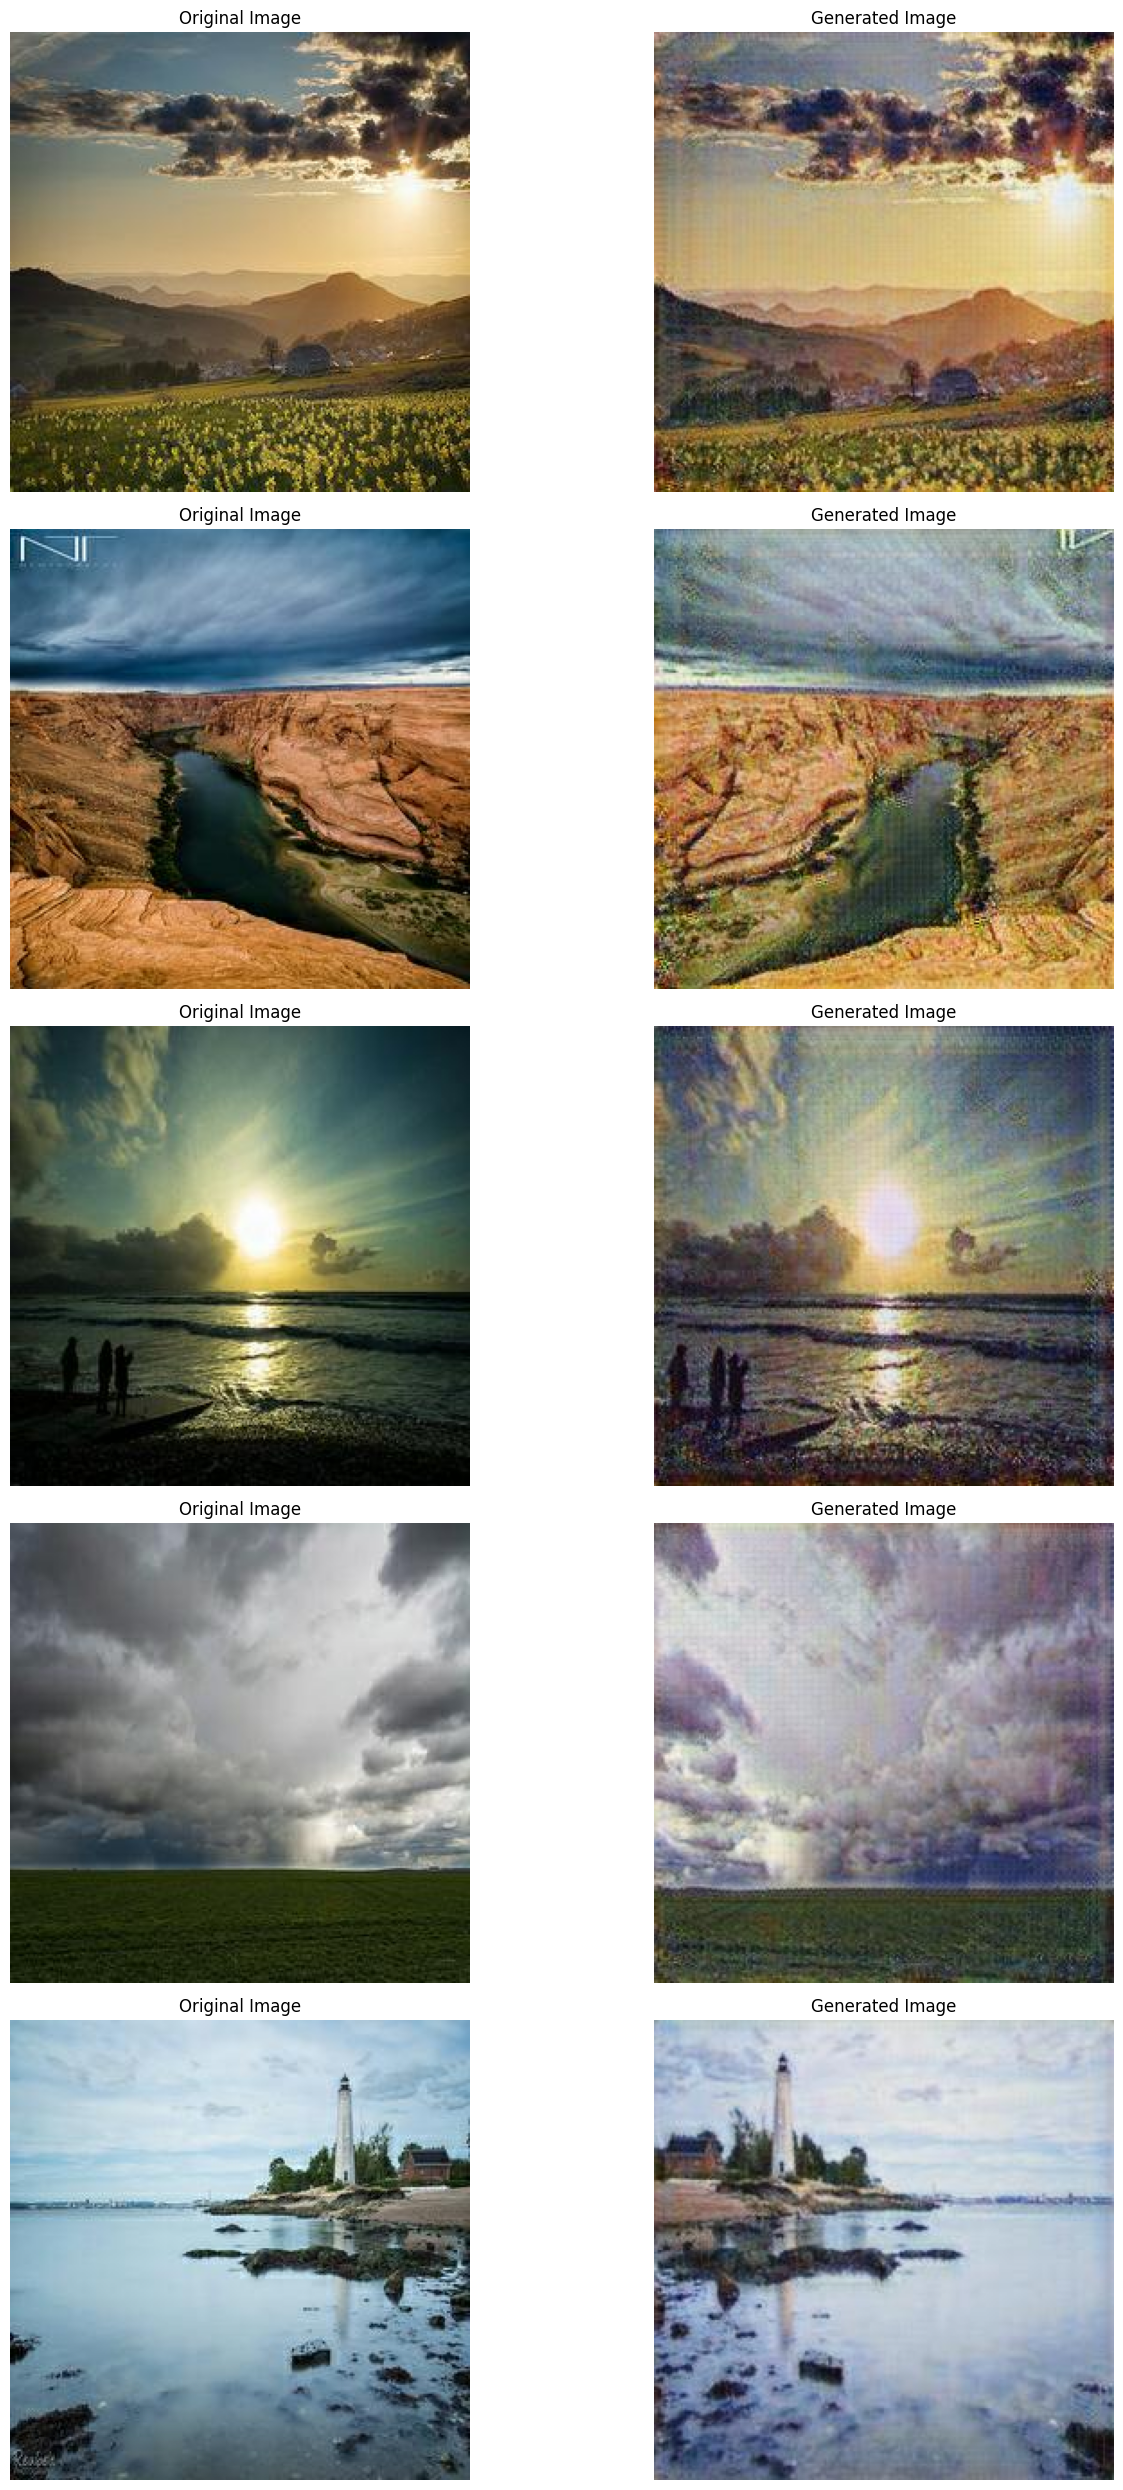

In [31]:
import os
from PIL import Image
import matplotlib.pyplot as plt

original_dir = "./photo_jpg"
generated_dir = "./generated_images"

original_images = sorted(os.listdir(original_dir))
generated_images = sorted(os.listdir(generated_dir))

num_images = min(len(original_images), len(generated_images))

num_to_display = 5
original_images = original_images[:num_to_display]
generated_images = generated_images[:num_to_display]

plt.figure(figsize=(15, 5 * num_to_display))
for i, (orig_file, gen_file) in enumerate(zip(original_images, generated_images)):
    orig_path = os.path.join(original_dir, orig_file)
    gen_path = os.path.join(generated_dir, gen_file)
    orig_img = Image.open(orig_path)
    gen_img = Image.open(gen_path)

    plt.subplot(num_to_display, 2, 2 * i + 1)
    plt.imshow(orig_img)
    plt.axis("off")
    plt.title("Original Image")

    plt.subplot(num_to_display, 2, 2 * i + 2)
    plt.imshow(gen_img)
    plt.axis("off")
    plt.title("Generated Image")

plt.tight_layout()
plt.show()

In [32]:
from pytorch_fid import fid_score
fid_value = fid_score.calculate_fid_given_paths(
    paths=["./monet_jpg", "./generated_images"],
    batch_size=50,
    device="cuda",
    dims=2048
)
print(f"FID Score: {fid_value}")

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 209MB/s]
100%|██████████| 141/141 [00:12<00:00, 10.87it/s]


FID Score: 101.97479097852568


In [33]:
import os
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim

original_dir = "./photo_jpg"
generated_dir = "./generated_images"

original_images = sorted(os.listdir(original_dir))
generated_images = sorted(os.listdir(generated_dir))

def calculate_ssim(original_image_path, generated_image_path):
    original = Image.open(original_image_path)
    generated = Image.open(generated_image_path)

    #generated = generated.resize(original.size)

    original_np = np.array(original)
    generated_np = np.array(generated)

    score = ssim(original_np, generated_np, multichannel=True, win_size=3)
    return score

ssim_scores = []
for orig, gen in zip(original_images, generated_images):
    orig_path = os.path.join(original_dir, orig)
    gen_path = os.path.join(generated_dir, gen)

    score = calculate_ssim(orig_path, gen_path)
    ssim_scores.append(score)

average_ssim = sum(ssim_scores) / len(ssim_scores)
print(f"Average SSIM: {average_ssim}")


Average SSIM: 0.39655618027466066


sources: This project referenced the following resource: https://www.kaggle.com/code/yeongseoplee/cyclegan-lsgan-loss-resnet-by-pytorch-lightning